# Analisis bibliográfico

## Rutinas

In [26]:
import pandas as pd
import numpy as np
import geopandas
import geoplot
import string
import re
import matplotlib.pyplot as plt
import altair as alt

## repairDataFrame

In [2]:
def repairDataFrame(df):
    """
    * Elimina ';' al final de los campos
    * Reemplaza NaN por cero.
    """
    for col in df.columns:
        
        ## reemplaza los NaN
        df[col] = [0 if isinstance(x, (int, float)) and np.isnan(x) else x for x in df[col]]
        
        ## elimina el caracter delimitador
        df[col] = [x[:-1] if isinstance(x, str) and x[-1] == ';' else x for x in df[col]]
    
    return df

In [3]:
citations = pd.read_csv('scopus-citations.csv')
abstracts = pd.read_csv('scopus-abstracts.csv')
abstracts = abstracts[['Abstract', 'Author Keywords']]
full = pd.concat([citations, abstracts], axis=1)
full['selected'] = [False] * len(full)

full = full[['selected', 'Year', 'Title', 'Authors', 'Author(s) ID', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Affiliations', 'Authors with affiliations', 'Document Type',
       'Publication Stage', 'Source', 'EID', 'Abstract', 'Author Keywords']]

full = full.sort_values(by=['selected','Year', 'Title'])

full.to_json('scopus-full-automatic.json', orient='records', lines=True)

records = pd.read_json('scopus-full-manual.json', orient='records', lines=True)
records = records[records.selected == True]
records = repairDataFrame(records)

## Consultas directas

In [4]:
##
## Numero de registros finalmente seleccionados
##
len(records)

156

In [13]:
##
## Cantidad de fuentes
##
len(records['Source title'].unique())

107

In [5]:
##
## Documentos más citados
##
records.sort_values(by='Cited by', ascending=False)[['Title', 'Authors', 'Year', 'Cited by']][0:10]

Title  \
434  Rise of the machines: Algorithmic trading in t...   
325          The Penn-Lehman Automated Trading Project   
443  Application of evolutionary computation for ru...   
417  Automated trading with performance weighted ra...   
350  Automated trading with boosting and expert wei...   
368  Intra-daily volume modeling and prediction for...   
344  Flexible least squares for temporal data minin...   
477  Robust technical trading strategies using GP f...   
73                          Algorithmic trading review   
400  Portfolio of automated trading systems: Comple...   

                                               Authors  Year  Cited by  
434  Chaboud A.P., Chiquoine B., Hjalmarsson E., Ve...  2014     105.0  
325                                Kearns M., Ortiz L.  2003      49.0  
443  Hu Y., Liu K., Zhang X., Su L., Ngai E.W.T., L...  2015      45.0  
417                 Booth A., Gerding E., McGroarty F.  2014      38.0  
350                              Creamer G., Freund Y.  2010      31.0  
368           Brownlees C.T., Cipollini F., Gallo G.M.  2011      29.0  
344     Montana G., Triantafyllopoulos K., Tsagaris T.  2009      23.0  
477      Berutich J.M., López F., Luna F., Quintana D.  2016      21.0  
73                 Treleaven P., Galas M., Lalchand V.  2013      20.0  
400                                          Raudys S.  2013      20.0

## documentsByTerm

In [55]:
def documentsByTerm(df, term, sep=None):
    
    if sep is not None:
        terms = [x  for x in df[term] if x is not None]
        df = pd.DataFrame({
            term: [y.strip() for x in terms for y in x.split(sep) if x is not None]
        })
        
    return df.groupby(term).size()

In [56]:
##
## Documentos por tipo
##
documentsByTerm(records, 'Document Type')

Document Type
Article              72
Book Chapter          5
Conference Paper     72
Conference Review     1
Note                  1
Review                5
dtype: int64

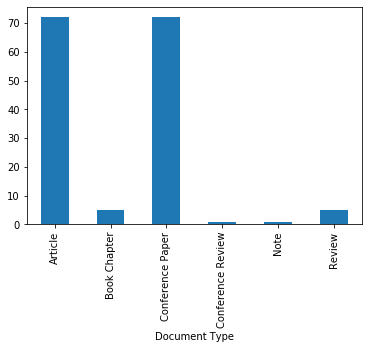

In [57]:
documentsByTerm(records, 'Document Type').plot.bar();

In [58]:
##
## Citas por documento
##
documentsByTerm(records, 'Cited by')

Cited by
0.0      61
1.0      16
2.0      12
3.0      10
4.0       9
5.0       6
6.0       5
7.0      10
8.0       1
9.0       3
11.0      4
12.0      1
13.0      1
14.0      2
15.0      2
16.0      1
18.0      1
19.0      1
20.0      2
21.0      1
23.0      1
29.0      1
31.0      1
38.0      1
45.0      1
49.0      1
105.0     1
dtype: int64

In [59]:
##
## Num Autores por documento
##
records['Num Authors'] = records['Author(s) ID'].map(lambda x: len(x.split(';')))
documentsByTerm(records, 'Num Authors')

Num Authors
1    21
2    54
3    41
4    24
5    11
6     5
dtype: int64

In [60]:
##
## Num documentos por fuente
##
documentsByTerm(records, 'Source title').sort_values(ascending=False)

Source title
Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)    17
Quantitative Finance                                                                                                                     9
Expert Systems with Applications                                                                                                         9
Communications in Computer and Information Science                                                                                       4
Computational Economics                                                                                                                  3
                                                                                                                                        ..
Journal of Financial Markets                                                                                                             1
Journal of Inf

In [61]:
##
## Número de documentos por autor
##
documentsByTerm(records, 'Authors', sep=',').sort_values(ascending=False)

Authors
Maringer D.     5
Ng W.L.         4
Kablan A.       4
Montana G.      4
Arévalo A.      3
               ..
Orihara R.      1
Ortiz L.        1
Otero F.E.B.    1
O’Neill M.      1
Lin J.-Y.       1
Length: 356, dtype: int64

In [62]:
##
## Número de documentos por keyword
##
documentsByTerm(records, 'Author Keywords', sep=';').sort_values(ascending=False)

Author Keywords
Algorithmic trading              30
Automated trading                10
Machine learning                  9
High-frequency trading            9
Deep learning                     8
                                 ..
Securities trading simulation     1
Semantic Web                      1
Semantics                         1
Sentiment Analysis                1
?-stable processes                1
Length: 425, dtype: int64

## extractCountries

In [63]:
def extractCountries(df):
    
    term = df.Affiliations
    
    ##
    ## lista generica de nombres de paises
    ##
    country_names = sorted(geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')).name.tolist())
        
    ## paises faltantes / nombres incompletos
    country_names.append('United States')           # United States of America
    country_names.append('Singapore')               #
    country_names.append('Russian Federation')      # Russia
    country_names.append('Czech Republic')          # Czechia
    country_names.append('Bosnia and Herzegovina')  # Bosnia and Herz.
    country_names.append('Malta')

    ##
    ## Reemplazo de nombres de regiones administrativas
    ## por nombres de paises
    ##
    term = [re.sub('Bosnia and Herzegovina', 'Bosnia and Herz.', t) if t is not None else t for t in term]
    term = [re.sub('Czech Republic', 'Czechia', t) if t is not None else t for t in term]
    term = [re.sub('Russian Federation', 'Russia', t) if t is not None else t for t in term]
    term = [re.sub('Hong Kong', 'China', t) if t is not None else t for t in term]
    term = [re.sub('Macau', 'China', t) if t is not None else t for t in term]
    term = [re.sub('Macao', 'China', t) if t is not None else t for t in term]
    term = [t if t is not None else '' for t in term ]

    countries = [[affiliation.split(',')[-1].strip() for affiliation in x.split(';')] for x in term]
    countries =  [ ';'.join([country if (country in country_names) else '' for country in country_list]) for country_list in countries]
        
    return [None if t == '' else t for t in countries ]

In [65]:
##
## Documentos por pais
##
records['Country'] = extractCountries(records)
documentsByTerm(records, 'Country', sep=';').sort_values(ascending=False)[0:10]

Country
United Kingdom    42
China             36
United States     26
Brazil            12
Italy             10
Germany            9
Canada             8
Colombia           8
Spain              7
Russia             6
dtype: int64

## documentsByYear

In [66]:
def documentsByYear(df, plot=False, cumulative=False):
    
    docs_per_year = pd.Series(0, index=range(min(df.Year), max(df.Year)+1))
    
    df0 = records.groupby('Year')[['Year']].count()
    for idx, x in zip(df0.index, df0.Year):
        docs_per_year[idx] = x
    docs_per_year = docs_per_year.to_frame()
    docs_per_year['Year'] = docs_per_year.index
    docs_per_year.columns = ['Documents', 'Year']
    
    if cumulative is True:
        docs_per_year.Documents = docs_per_year.Documents.cumsum()

    if plot is True:
        return alt.Chart(docs_per_year).mark_bar().encode(
            alt.X('Year:Q',
                  axis=alt.Axis(labelAngle=270)),
            y='Documents:Q'
        )
    else:
        return docs_per_year

In [67]:
documentsByYear(records)

Documents  Year
1994          1  1994
1995          0  1995
1996          0  1996
1997          0  1997
1998          0  1998
1999          0  1999
2000          0  2000
2001          0  2001
2002          0  2002
2003          2  2003
2004          2  2004
2005          2  2005
2006          2  2006
2007          5  2007
2008          5  2008
2009          6  2009
2010          9  2010
2011          3  2011
2012         17  2012
2013         11  2013
2014         14  2014
2015          8  2015
2016         12  2016
2017         17  2017
2018         19  2018
2019         21  2019

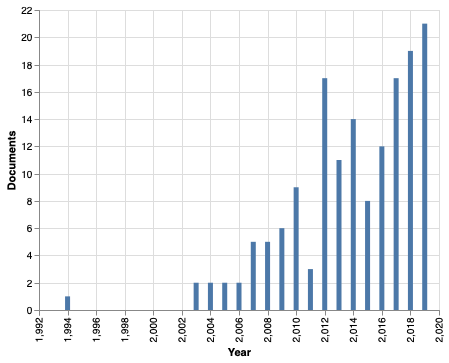

In [68]:
documentsByYear(records, plot=True)

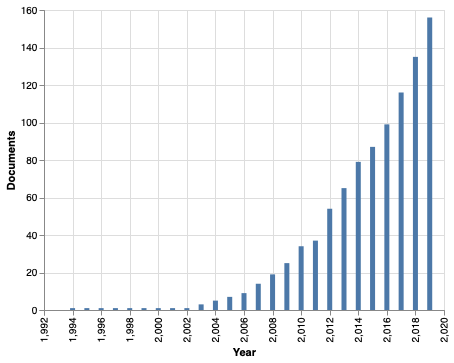

In [69]:
documentsByYear(records, plot=True, cumulative=True)

## citationsByYear

In [70]:
def citationsByYear(df, plot=False, cumulative=False):
    citations_per_year = pd.Series(0, index=range(min(df.Year), max(df.Year)+1))
    df0 = df.groupby(['Year'], as_index=False).agg({
        'Cited by': np.sum
    })
    for idx, x in zip(df0['Year'], df0['Cited by']):
        citations_per_year[idx] = x
    citations_per_year = citations_per_year.to_frame()
    citations_per_year['Year'] = citations_per_year.index
    citations_per_year.columns = ['Citations', 'Year']
    
    if cumulative is True:
        citations_per_year['Citations'] = citations_per_year['Citations'].cumsum()
        
    if plot is True:
        return alt.Chart(citations_per_year).mark_bar().encode(
            alt.X('Year:Q',
                  axis=alt.Axis(labelAngle=270)),
            y='Citations:Q'
        )
    else:
        return citations_per_year

In [71]:
citationsByYear(records)

Citations  Year
1994          3  1994
1995          0  1995
1996          0  1996
1997          0  1997
1998          0  1998
1999          0  1999
2000          0  2000
2001          0  2001
2002          0  2002
2003         49  2003
2004          6  2004
2005          6  2005
2006          3  2006
2007         12  2007
2008         20  2008
2009         56  2009
2010         61  2010
2011         30  2011
2012        103  2012
2013         54  2013
2014        188  2014
2015         55  2015
2016         79  2016
2017         59  2017
2018         39  2018
2019          9  2019

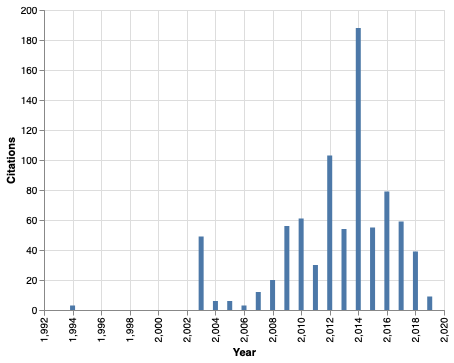

In [72]:
citationsByYear(records, plot=True)

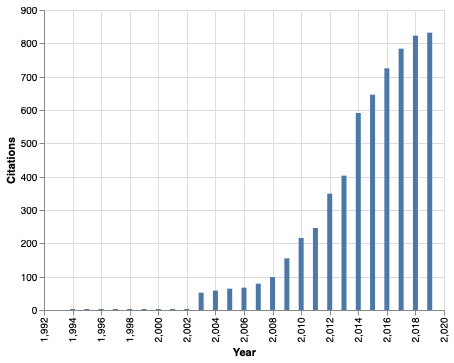

In [73]:
citationsByYear(records, plot=True, cumulative=True)

## termByTerm

In [213]:
def termByTerm(df, termA, termB, sepA=None, sepB=None, 
               ascendingA=None, ascendingB=None, minmax=None,
               plot=False, figsize=(10,10)):
    
    df = df[[termA, termB]].dropna()
    
    ##
    ## Expande las dos columnas de los datos originales
    ##
    if sepA is None and sepB is None:
        df = df[[termA, termB]]
    
    if sepA is not None and sepB is None:
        
        t = [(x, y) for x, y in zip(df[termA], df[termB])]
        t = [(c, b) for a, b in t for c in a.split(sepA)]
        df = pd.DataFrame({
            termA: [a for a,b in t],
            termB: [b for a,b in t]
        })
        
    if sepA is None and sepB is not None:
    
        t = [(x, y) for x, y in zip(df[termA], df[termB])]
        t = [(a, c) for a, b in t for c in b.split(sepB)]
        df = pd.DataFrame({
            termA: [a for a,b in t],
            termB: [b for a,b in t]
        })

    if sepA is not None and sepB is not None:
    
        t = [(x, y) for x, y in zip(df[termA], df[termB])]
        t = [(c, b) for a, b in t for c in a.split(sepA)]
        t = [(a, c) for a, b in t for c in b.split(sepB)]
        df = pd.DataFrame({
            termA: [a for a,b in t],
            termB: [b for a,b in t]
        })

    if termA == 'Year':
        termA_unique = range(min(df.Year), max(df.Year)+1)
    else:
        termA_unique = df[termA].unique()
        
    if termB == 'Year':
        termB_unique = range(min(df.Year), max(df.Year)+1)
    else:
        termB_unique = df[termB].unique()
        
    if ascendingA is not None:
        termA_unique = sorted(termA_unique, reverse = not ascendingA)

    if ascendingB is not None:
        termB_unique = sorted(termB_unique, reverse = not ascendingB)

    result = pd.DataFrame(
        np.zeros((len(termA_unique), len(termB_unique)))
    )
    
    result.columns = termB_unique
    result.index = termA_unique

    for  a,b in zip(df[termA], df[termB]):
        result.loc[a, b] += 1
    
    if minmax is not None:

        minval, maxval = minmax
        r = result.copy()
       
        for a in termA_unique:
            for b in termB_unique:
                if r.loc[a, b] < minval or r.loc[a, b] > maxval:
                    r.loc[a, b] = np.nan
        
        r = r.dropna(axis='index', how='all')
        r = r.dropna(axis='columns', how='all')
        result = result[r.columns]
        result = result.loc[r.index,:]
    
    if plot is True:
        plt.figure(figsize=figsize)
        plt.pcolor(result.values, cmap='Greys')
        plt.xticks(np.arange(len(result.columns))+0.5, result.columns, rotation='vertical')
        plt.yticks(np.arange(len(result.index))+0.5, result.index)
        plt.gca().set_aspect('equal', 'box')
        plt.gca().invert_yaxis()
        
    else:
        return result


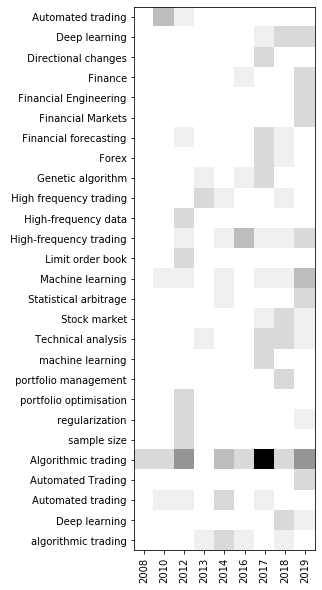

In [214]:
##
## Palabras clave por año
##
termByTerm(records, 'Author Keywords', 'Year', sepA=';', sepB=None, 
           ascendingA=True, ascendingB=True, minmax=(2,3), plot=True)

In [166]:
##
## Palabras clave por año
##
termByTerm(records, 'Author Keywords', 'Year', sepA=';', sepB=None, 
           ascendingA=True, ascendingB=True, minmax=(2,3))

2008  2010  2012  2013  2014  2016  2017  2018  2019
 Automated trading        0.0   3.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0
 Deep learning            0.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   2.0
 Directional changes      0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0
 Finance                  0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   2.0
 Financial Engineering    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0
 Financial Markets        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0
 Financial forecasting    0.0   0.0   1.0   0.0   0.0   0.0   2.0   1.0   0.0
 Forex                    0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   0.0
 Genetic algorithm        0.0   0.0   0.0   1.0   0.0   1.0   2.0   0.0   0.0
 High frequency trading   0.0   0.0   0.0   2.0   1.0   0.0   0.0   1.0   0.0
 High-frequency data      0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0
 High-frequency trading   0.0   0.0   1.0   0.0   1.0   3.0   1.0   1.0   2.0
 Limit order book         0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0
 Machine learning         0.0   1.0   1.0   0.0   1.0   0.0   1.0   1.0   3.0
 Statistical arbitrage    0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   2.0
 Stock market             0.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   1.0
 Technical analysis       0.0   0.0   0.0   1.0   0.0   0.0   2.0   2.0   1.0
 machine learning         0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0
 portfolio management     0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0
 portfolio optimisation   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0
 regularization           0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0
 sample size              0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0
Algorithmic trading       2.0   2.0   4.0   0.0   3.0   2.0   8.0   2.0   4.0
Automated Trading         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0
Automated trading         0.0   1.0   1.0   0.0   2.0   0.0   1.0   0.0   0.0
Deep learning             0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0
algorithmic trading       0.0   0.0   0.0   1.0   2.0   1.0   0.0   1.0   0.0

In [167]:
##
## Palabras clave por autor
##
termByTerm(records, 'Authors', 'Author Keywords', sepA=',', sepB=';')

Decision support system   Intelligent agents  \
Wang Y.                                1.0                  1.0   
 Wang H.                               1.0                  1.0   
 Deng J.                               1.0                  1.0   
 Zhao X.                               1.0                  1.0   
 Yung K.                               1.0                  1.0   
...                                    ...                  ...   
 Levendovszky J.                       0.0                  0.0   
 Fogarasi N.                           0.0                  0.0   
Gómez Martínez R.                      0.0                  0.0   
 Prado Román M.                        0.0                  0.0   
 Plaza Casado P.                       0.0                  0.0   

                    Securities trading simulation   Web-services  \
Wang Y.                                       1.0            1.0   
 Wang H.                                      1.0            1.0   
 Deng J.                                      1.0            1.0   
 Zhao X.                                      1.0            1.0   
 Yung K.                                      1.0            1.0   
...                                           ...            ...   
 Levendovszky J.                              0.0            0.0   
 Fogarasi N.                                  0.0            0.0   
Gómez Martínez R.                             0.0            0.0   
 Prado Román M.                               0.0            0.0   
 Plaza Casado P.                              0.0            0.0   

                   Fibonacci geometry   Price patterns   Technical analysis  \
Wang Y.                           0.0              0.0                  0.0   
 Wang H.                          0.0              0.0                  0.0   
 Deng J.                          0.0              0.0                  0.0   
 Zhao X.                          0.0              0.0                  0.0   
 Yung K.                          0.0              0.0                  0.0   
...                               ...              ...                  ...   
 Levendovszky J.                  0.0              0.0                  0.0   
 Fogarasi N.                      0.0              0.0                  0.0   
Gómez Martínez R.                 0.0              0.0                  0.0   
 Prado Román M.                   0.0              0.0                  0.0   
 Plaza Casado P.                  0.0              0.0                  0.0   

                    Trading systems  Argumentation   Data mining  ...  \
Wang Y.                         0.0            0.0           0.0  ...   
 Wang H.                        0.0            0.0           0.0  ...   
 Deng J.                        0.0            0.0           0.0  ...   
 Zhao X.                        0.0            0.0           0.0  ...   
 Yung K.                        0.0            0.0           0.0  ...   
...                             ...            ...           ...  ...   
 Levendovszky J.                0.0            0.0           0.0  ...   
 Fogarasi N.                    0.0            0.0           0.0  ...   
Gómez Martínez R.               0.0            0.0           0.0  ...   
 Prado Román M.                 0.0            0.0           0.0  ...   
 Plaza Casado P.                0.0            0.0           0.0  ...   

                    Optimal historical data period selection  \
Wang Y.                                                  0.0   
 Wang H.                                                 0.0   
 Deng J.                                                 0.0   
 Zhao X.                                                 0.0   
 Yung K.                                                 0.0   
...                                                      ...   
 Levendovszky J.                                         0.0   
 Fogarasi N.                                             0.

In [168]:
##
## Palabras clave por año
##
termByTerm(records, 'Author Keywords', 'Year', sepA=';', sepB=None)

2004  2005  2006  2007  2008  2009  2010  \
Decision support system          0.0   1.0   0.0   0.0   0.0   0.0   0.0   
 Intelligent agents              0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 Securities trading simulation   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
 Web-services                    0.0   1.0   0.0   0.0   0.0   0.0   0.0   
Fibonacci geometry               0.0   0.0   1.0   0.0   0.0   0.0   0.0   
...                              ...   ...   ...   ...   ...   ...   ...   
 Neural network                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Support vector machine          0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Behavioral finance              0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Big data                        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Investors’ mood                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                2011  2012  2013  2014  2015  2016  2017  \
Decision support system          0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Intelligent agents              0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Securities trading simulation   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Web-services                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Fibonacci geometry               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                              ...   ...   ...   ...   ...   ...   ...   
 Neural network                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Support vector machine          0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Behavioral finance              0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Big data                        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 Investors’ mood                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                2018  2019  
Decision support system          0.0   0.0  
 Intelligent agents              0.0   0.0  
 Securities trading simulation   0.0   0.0  
 Web-services                    0.0   0.0  
Fibonacci geometry               0.0   0.0  
...                              ...   ...  
 Neural network                  0.0   1.0  
 Support vector machine          0.0   1.0  
 Behavioral finance              0.0   1.0  
 Big data                        0.0   1.0  
 Investors’ mood                 0.0   1.0  

[440 rows x 16 columns]

In [169]:
##
## Tipo de documento por año
##
termByTerm(records, 'Document Type', 'Year', sepA=None, sepB=None)

1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  \
Conference Paper    1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
Article             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Review              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
Book Chapter        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Note                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Conference Review   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                   ...  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Conference Paper   ...   8.0   1.0   6.0   2.0   7.0   4.0   4.0  12.0   8.0   
Article            ...   1.0   2.0  11.0   6.0   7.0   2.0   8.0   5.0  10.0   
Review             ...   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0   
Book Chapter       ...   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   
Note               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Conference Review  ...   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   

                   2019  
Conference Paper    5.0  
Article            14.0  
Review              0.0  
Book Chapter        1.0  
Note                1.0  
Conference Review   0.0  

[6 rows x 26 columns]

In [170]:
##
## Palabras clave por año
##
termByTerm(records, 'Author Keywords', 'Year', sepA=';', sepB=None, 
           ascendingA=True, ascendingB=False)

2019  2018  2017  2016  2015  2014  2013  2012  \
 ANFIS ensemble                 0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
 ANN                            0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
 Algorithmic trading            0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
 Artificial intelligence        1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
 Artificial neural network      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
...                             ...   ...   ...   ...   ...   ...   ...   ...   
biclustering algorithm          0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
classification                  1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
complex event processing        0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
convolutional neural networks   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
emerging markets                0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   

                               2011  2010  2009  2008  2007  2006  2005  2004  
 ANFIS ensemble                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 ANN                            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 Algorithmic trading            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 Artificial intelligence        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 Artificial neural network      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...                             ...   ...   ...   ...   ...   ...   ...   ...  
biclustering algorithm          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
classification                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
complex event processing        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
convolutional neural networks   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
emerging markets                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[440 rows x 16 columns]

In [215]:
##
## Autor por tipo de documento
##
termByTerm(records, 'Authors', 'Document Type', sepA=',', sepB=None)

Conference Paper  Article  Review  Book Chapter  Note  \
Silaghi G.C.                    1.0      0.0     0.0           0.0   0.0   
 Robu V.                        1.0      0.0     0.0           0.0   0.0   
Wang Y.                         1.0      0.0     0.0           0.0   0.0   
 Wang H.                        1.0      0.0     0.0           0.0   0.0   
 Deng J.                        1.0      0.0     0.0           0.0   0.0   
...                             ...      ...     ...           ...   ...   
 Levendovszky J.                0.0      1.0     0.0           0.0   0.0   
 Fogarasi N.                    0.0      1.0     0.0           0.0   0.0   
Gómez Martínez R.               0.0      1.0     0.0           0.0   0.0   
 Prado Román M.                 0.0      1.0     0.0           0.0   0.0   
 Plaza Casado P.                0.0      1.0     0.0           0.0   0.0   

                   Conference Review  
Silaghi G.C.                     0.0  
 Robu V.                         0.0  
Wang Y.                          0.0  
 Wang H.                         0.0  
 Deng J.                         0.0  
...                              ...  
 Levendovszky J.                 0.0  
 Fogarasi N.                     0.0  
Gómez Martínez R.                0.0  
 Prado Román M.                  0.0  
 Plaza Casado P.                 0.0  

[367 rows x 6 columns]

In [ ]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
world.columns

In [ ]:
geoplot.choropleth(
    world, hue=world['gdp_md_est'] / world['pop_est'],
    cmap='Greens', figsize=(8, 4)
)

In [ ]:
world.name

## Lectura de datos -- Documentos recuperados automáticamente

### 1. ---->>>  Búsqueda en Scopus  <<<----

Realice la búsqueda de documentos en Scopus usando su cadena de búsqueda. Genere los archivos `scopus-citations.csv` y `scopus-abstracts.csv`.

### 2.

Cargue los archivos generados en la búsqueda automática.

In [ ]:
citations = pd.read_csv('scopus-citations.csv')

Construya el archivo `scopus-abstract.csv` con los campos `Abstract` y `Author Keywords`.

In [ ]:
abstracts = pd.read_csv('scopus-abstracts.csv')
abstracts = abstracts[['Abstract', 'Author Keywords']]

### 3.

Concatene la información bibliográfica con el abstract y las palabras clave de los autores.

In [ ]:
full = pd.concat([citations, abstracts], axis=1)

### 4.

Agregue el campo `selected` y reorganice el orden de las columnas.

In [ ]:
full['selected'] = [False] * len(full)

full = full[['selected', 'Year', 'Title', 'Authors', 'Author(s) ID', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Affiliations', 'Authors with affiliations', 'Document Type',
       'Publication Stage', 'Source', 'EID', 'Abstract', 'Author Keywords']]

full = full.sort_values(by=['selected','Year', 'Title'])

In [ ]:
full.columns

### 5.

Genere el archivo `scopus-full-automatic.json` con la bibliografia seleccionada.

In [ ]:
full.to_json('scopus-full-automatic.json', orient='records', lines=True)

## Lectura de datos -- Documentos filtrados manualmente

### 6. ----->>> FILTRADO MANUAL <<<-----

Haga una copia del archivo anterior y salvela como `scopus-full-manual.csv`. Edite este archivo con Visual Studio Code. Seleccione los documentos que haran parte de su bibliografía, cambiando el valor del campo `selected` de `false` a `true`.

### 7.

Obtenga los registros bibliográficos finalmente seleccionados

In [ ]:
records = pd.read_json('scopus-full-manual.json', orient='records', lines=True)
records = records[records.selected == True]
records = repairDataFrame(records)

##
## Numero de registros finalmente seleccionados
##
len(records)

Busque artículos duplicados

In [ ]:


def asciify(text):
    def translate(c):
        if c in ['\u00C0', '\u00C1', '\u00C2', '\u00C3', '\u00C4', 
                 '\u00C5', '\u00E0', '\u00E1', '\u00E2', '\u00E3',
                 '\u00E4', '\u00E5', '\u0100', '\u0101', '\u0102', 
                 '\u0103', '\u0104', '\u0105']:
            return 'a'
        if c in ['\u00C7', '\u00E7', '\u0106', '\u0107', '\u0108',
                 '\u0109', '\u010A', '\u010B', '\u010C', '\u010D']:
            return 'c'
        if c in ['\u00D0', '\u00F0', '\u010E', '\u010F', '\u0110',
                 '\u0111']:
            return 'd'
        if c in ['\u00C8', '\u00C9', '\u00CA', '\u00CB', '\u00E8',
                 '\u00E9', '\u00EA', '\u00EB', '\u0112', '\u0113',
                 '\u0114', '\u0115', '\u0116', '\u0117', '\u0118',
                 '\u0119', '\u011A', '\u011B']:
            return 'e'
        if c in ['\u011C', '\u011D', '\u011E', '\u011F', '\u0120',
                 '\u0121', '\u0122 ', '\u0123']:
            return 'g'
        if c in ['\u0124', '\u0125', '\u0126', '\u0127']:
            return 'h'
        if c in ['\u00CC', '\u00CD', '\u00CE', '\u00CF', '\u00EC', 
                 '\u00ED', '\u00EE', '\u00EF', '\u0128', '\u0129',
                 '\u012A', '\u012B', '\u012C', '\u012D', '\u012E',
                 '\u012F', '\u0130', '\u0131']:
            return 'i'
        if c in ['\u0134', '\u0135']:
            return 'j'
        if c in ['\u0136', '\u0137', '\u0138']:
            return 'k'
        if c in ['\u0139', '\u013A', '\u013B', '\u013C', '\u013D',
                 '\u013E', '\u013F', '\u0140', '\u0141', '\u0142']:
            return 'l'
        if c in ['\u00D1', '\u00F1', '\u0143', '\u0144', '\u0145',
                 '\u0146', '\u0147', '\u0148', '\u0149', '\u014A',
                 '\u014B']:
            return 'n'
        if c in ['\u00D2', '\u00D3', '\u00D4', '\u00D5', '\u00D6',
                 '\u00D8', '\u00F2', '\u00F3', '\u00F4', '\u00F5',
                 '\u00F6', '\u00F8', '\u014C', '\u014D', '\u014E',
                 '\u014F', '\u0150', '\u0151']:
            return 'o'
        if c in ['\u0154', '\u0155', '\u0156', '\u0157', '\u0158',
                 '\u0159']:
            return 'r'
        if c in ['\u015A', '\u015B', '\u015C', '\u015D', '\u015E',
                 '\u015F', '\u0160', '\u0161', '\u017F']:
            return 's'
        if c in ['\u0162', '\u0163', '\u0164', '\u0165', '\u0166',
                 '\u0167']:
            return 't'
        if c in ['\u00D9', '\u00DA', '\u00DB', '\u00DC', '\u00F9',
                 '\u00FA', '\u00FB', '\u00FC', '\u0168', '\u0169',
                 '\u016A', '\u016B', '\u016C', '\u016D', '\u016E',
                 '\u016F', '\u0170', '\u0171', '\u0172', '\u0173']:
            return 'u'
        if c in ['\u0174', '\u0175']:
            return 'w'
        if c in ['\u00DD', '\u00FD', '\u00FF', '\u0176', '\u0177',
                 '\u0178']:
            return 'y'
        if c in ['\u0179', '\u017A', '\u017B', '\u017C', '\u017D',
                 '\u017E']:
            return 'z'
        return c

    return ''.join([translate(c) for c in text])


def fingerprint_collision(texts):
    texts = [text.strip() for text in texts]
    texts = [text.lower() for text in texts]
    texts = [re.sub('['+string.punctuation+']', '', text) for text in texts]
    texts = [asciify(text) for text in texts]
    texts = [' '.join({x for x in text.split()}) for text in texts]
    texts = [' '.join(sorted(text.split())) for text in texts]
    return texts
    
    
records['Title_collision'] = fingerprint_collision(records.Title)
records = records.sort_values(by='Title_collision')

for idx in range(len(records.index)-1):
    if records.Title_collision[records.index[idx]] == records.Title_collision[records.index[idx + 1]]:
        print(records.index[idx], records.Title[records.index[idx]])
        print(records.index[idx+1], records.Title[records.index[idx+1]])
        print('-------')
        
# 324 Performance analysis of a counter-intuitive automated stock-trading agent
# 323 Performance Analysis of a Counter-Intuitive Automated Stock-Trading Agent
# -------
# 382 Prediction based - High frequency trading on financial time series
# 401 Prediction based - High Frequency Trading on Financial Time Series
# -------
# 454 Knowledge discovery in dynamic data using neural networks
# 453 Knowledge discovery in dynamic data using neural networks

### 9.

### Análisis Básico

In [ ]:
##
## Número de documentos por institución
##
documentsByTerm(records, 'Affiliations', expand=True, sep=';').sort_values(ascending=False)[60:120]

In [ ]:
!pip3 install vega_datasets


In [ ]:
import altair as alt
from vega_datasets import data

source = alt.topo_feature(data.world_110m.url, 'countries')

alt.Chart(source).mark_geoshape(
    fill='white',
    stroke='black'
).properties(
    width=600,
    height=280
).project(
    'equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', variable_list)
)

In [ ]:
source

In [ ]:
##
## World map
## 


In [ ]:
 counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

In [ ]:
counties

In [ ]:
alt.topo_feature(data.world_110m.url, 'countries')

In [ ]:
alt.topo_feature(data.us_10m.url, 'states')

In [ ]:
!pip3 install mapclassify

### Citas por año

### Tabla de resumen de autores

In [ ]:
##
## Autores
##
authors = pd.DataFrame({
    'Authors': [y.strip()  for x in records.Authors for y in x.split(',')],
    'Author(s) ID': [y.strip()  for x in records['Author(s) ID'] for y in x.split(';')], 
    'Cited by': [z  for x, z in zip(records['Author(s) ID'], records['Cited by']) for y in x.split(';')],
    'Year': [z  for x, z in zip(records['Author(s) ID'], records.Year) for y in x.split(';')]
})
authors[0:10]

### Numero total de autores diferentes

In [ ]:
len(authors['Author(s) ID'].unique())

### Tabla de cantidad de documentos y citas por autor

In [ ]:
docs_cites_per_author = authors.groupby(['Author(s) ID', 'Authors'], as_index=False).agg({
    'Year': np.size,
    'Cited by': np.sum
}).rename(columns={'Year':'Documents'})

docs_cites_per_author['Impact factor'] = docs_cites_per_author['Cited by'] / docs_cites_per_author['Documents']

docs_cites_per_author[0:10]

### Autores más citados

In [ ]:
docs_cites_per_author.sort_values(by='Cited by', ascending=False)[0:30]

### Autores con mayor factor de impacto

In [ ]:
docs_cites_per_author.sort_values(by='Impact factor', ascending=False)[0:30]

### Número de documentos por autor

In [ ]:
docs_cites_per_author.sort_values(by='Documents', ascending=False)[0:20]

### Cantidad de documentos por el mismo autor

In [ ]:
num_documents_per_num_authors = docs_cites_per_author.Documents.value_counts().sort_index()
num_documents_per_num_authors

### Tabla de cantidad de documentos y citas por autor por año

In [ ]:
docs_cites_per_author_per_year = authors.groupby(['Author(s) ID', 'Authors', 'Year'], as_index=False).agg({
    'Cited by': np.sum
})
num_docs = authors.groupby(['Author(s) ID', 'Authors', 'Year']).count()
docs_cites_per_author_per_year['Num docs'] = num_docs['Cited by'].tolist()

docs_cites_per_author_per_year[0:10]

In [ ]:
docs_cites_per_author_per_year.sort_values(by=['Cited by', 'Year'], ascending=False)[0:20]

### Cantidad de fuentes por cantidad de documentos

In [ ]:
records.groupby('Source title').size().sort_values(ascending=False).value_counts().sort_index()

### Cantidad de citas por fuente

In [ ]:
(records.groupby('Source title').sum()[['Cited by']]).sort_values(by='Cited by', ascending=False)[0:10]